In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torch  import is_tensor
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import torchvision
import torch.nn.functional as F

In [ ]:
!git clone https://github.com/ahmedtarek1325/CNN-tutorial.git

fatal: destination path 'CNN-tutorial' already exists and is not an empty directory.


In [ ]:
import sys
sys.path.append('/kaggle/working/CNN-tutorial')
from data import perPixel_mean_std, perChannel_mean_std, build_transforms

In [ ]:
class MyDataset(Dataset):
    def __init__(self,x,y,transforms = None):
        self.x = x
        self.y = y
        self.transforms = transforms
    def __len__(self):
        return len(self.y)
    def __getitem__(self,idx):
        if self.transforms is not None:
            x= self.transforms(image= self.x[idx])['image']
            return x.type(torch.float32),self.y[idx]

        return self.x[idx],self.y[idx]


def train_batch(input, model, criterion, optimizer, device):
    model.train()
    input = input.to(device)
    optimizer.zero_grad()
    output = model(input)
    loss = criterion(output, input)
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def validate_batch(input, model, criterion, device):
    model.eval()
    input = input.to(device)
    output = model(input)
    loss = criterion(output, input)
    return loss.item()

In [ ]:
train_data  = datasets.CIFAR10(root='./data',train = True,download = True)
val_data = datasets.CIFAR10(root='/data',train=False,download = True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# stratify to keep the ratio 0.9 for every class in the trainined and testing
uni, counts = np.unique(y_val, return_counts=True)
counts

array([500, 500, 500, 500, 500, 500, 500, 500, 500, 500])

In [ ]:
mean_,std_ = perChannel_mean_std(X_train,'NHWC')
mean_,std_

(array([125.24002457, 122.93835269, 113.84449184]),
 array([62.95162973, 62.07468216, 66.70886545]))

In [ ]:
train_tansforms,test_transforms = build_transforms('pipeline1',{'mean':mean_,
                                                                 'std':std_})

In [ ]:
trainset = MyDataset(X_train,y_train,train_tansforms)
trainloader_ = DataLoader(trainset,batch_size=128, shuffle=True)

valset = MyDataset(X_val,y_val,test_transforms)
valloader_ = DataLoader(valset,batch_size=128, shuffle=False)

In [ ]:
class AEModel(nn.Module):
    def __init__(self, cin, cout, stride=1, groups=1):
        super(AEModel, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(cin, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, cout, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AEModel(cin=3, cout=3).to(device)
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [ ]:
summary(model, torch.rand(4,3,32,32));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256, 4, 4]           --
|    └─Conv2d: 2-1                       [-1, 64, 16, 16]          3,136
|    └─ReLU: 2-2                         [-1, 64, 16, 16]          --
|    └─Conv2d: 2-3                       [-1, 128, 8, 8]           131,200
|    └─ReLU: 2-4                         [-1, 128, 8, 8]           --
|    └─Conv2d: 2-5                       [-1, 256, 4, 4]           524,544
|    └─ReLU: 2-6                         [-1, 256, 4, 4]           --
├─Sequential: 1-2                        [-1, 3, 32, 32]           --
|    └─ConvTranspose2d: 2-7              [-1, 128, 8, 8]           524,416
|    └─ReLU: 2-8                         [-1, 128, 8, 8]           --
|    └─ConvTranspose2d: 2-9              [-1, 64, 16, 16]          131,136
|    └─ReLU: 2-10                        [-1, 64, 16, 16]          --
|    └─ConvTranspose2d: 2-11             [-1, 3, 32, 32]      

In [ ]:
num_epochs = 15
hist = {'train_loss': [], 'val_loss': []}
for epoch in range(num_epochs):
    train_loss_total = 0
    N_train = len(trainloader_)
    for ix, (data, _) in enumerate(trainloader_):
        train_loss = train_batch(data, model, loss, optimizer, device)
        train_loss_total += train_loss

    val_loss_total = 0
    N_val = len(valloader_)
    for ix, (data, _) in enumerate(valloader_):
        val_loss = validate_batch(data, model, loss, device)
        val_loss_total += val_loss

    train_loss_avg = train_loss_total / N_train
    val_loss_avg = val_loss_total / N_val

    print(f"Epoch {epoch+1}/{num_epochs} || Train Loss: {train_loss_avg:.4f} || Val Loss: {val_loss_avg:.4f}")

    hist['train_loss'].append(train_loss_avg)
    hist['val_loss'].append(val_loss_avg)

Epoch 1/15 || Train Loss: 0.2554 || Val Loss: 0.1705
Epoch 2/15 || Train Loss: 0.1592 || Val Loss: 0.1474
Epoch 3/15 || Train Loss: 0.1468 || Val Loss: 0.1389
Epoch 4/15 || Train Loss: 0.1413 || Val Loss: 0.1343
Epoch 5/15 || Train Loss: 0.1375 || Val Loss: 0.1313
Epoch 6/15 || Train Loss: 0.1349 || Val Loss: 0.1292
Epoch 7/15 || Train Loss: 0.1334 || Val Loss: 0.1279
Epoch 8/15 || Train Loss: 0.1322 || Val Loss: 0.1328
Epoch 9/15 || Train Loss: 0.1313 || Val Loss: 0.1247
Epoch 10/15 || Train Loss: 0.1291 || Val Loss: 0.1240
Epoch 11/15 || Train Loss: 0.1288 || Val Loss: 0.1234
Epoch 12/15 || Train Loss: 0.1271 || Val Loss: 0.1233
Epoch 13/15 || Train Loss: 0.1260 || Val Loss: 0.1220
Epoch 14/15 || Train Loss: 0.1270 || Val Loss: 0.1216
Epoch 15/15 || Train Loss: 0.1254 || Val Loss: 0.1207


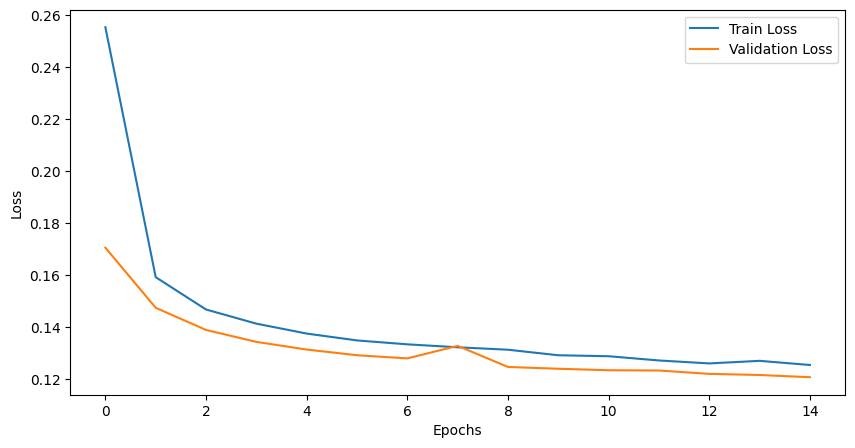

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(hist['train_loss'], label='Train Loss')
plt.plot(hist['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Mean Squared Error (MSE) of the reconstructed images: 0.0589


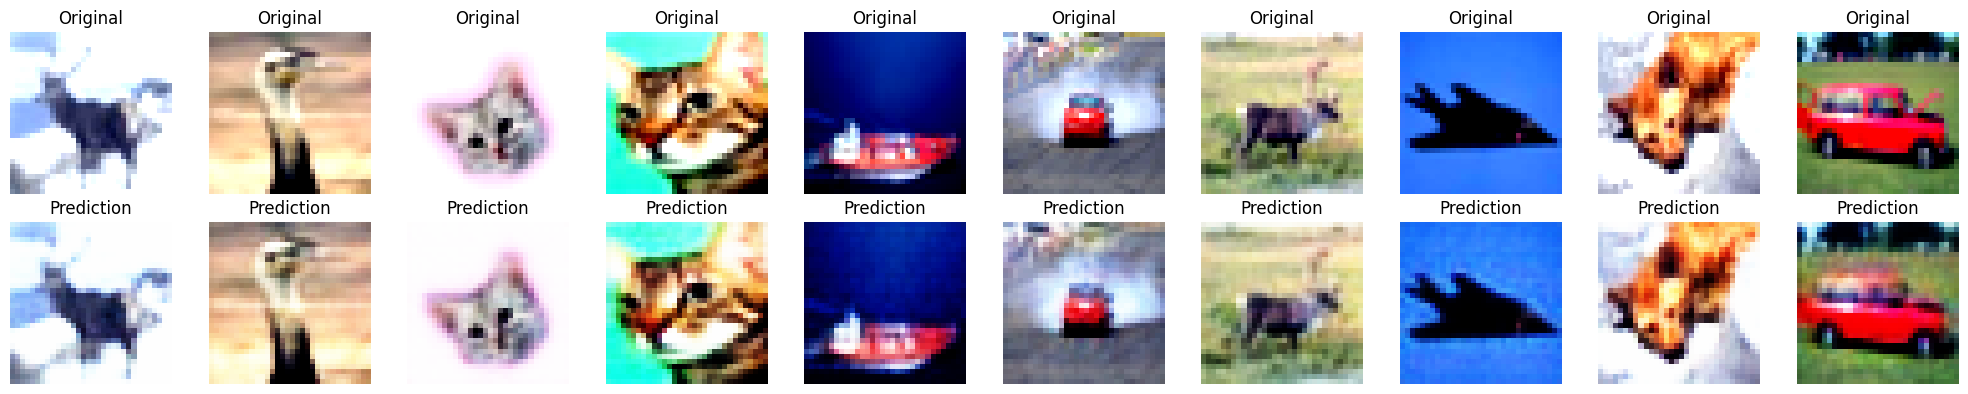

In [ ]:
def calculate_mse(original, reconstructed):
    return F.mse_loss(original, reconstructed).item()

def imshow(ax, img, title):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.set_title(title)
    ax.axis('off')

dataiter = iter(valloader_)
images, _ = next(dataiter)
indices = np.random.choice(len(valloader_.dataset), 10, replace=False)
images = [valloader_.dataset[i][0] for i in indices]
images = torch.stack(images).to(device)

model.eval()
with torch.no_grad():
    reconstructed = model(images)

# Calculating reconstruction quality
mse = calculate_mse(images, reconstructed)
print(f"Mean Squared Error (MSE) of the reconstructed images: {mse:.4f}")

fig, axes = plt.subplots(2, 10, figsize=(20, 4))

for i in range(10):
    imshow(axes[0, i], images[i].cpu(), title="Original")

for i in range(10):
    imshow(axes[1, i], reconstructed[i].cpu(), title="Prediction")

plt.tight_layout()
plt.show()